# Week 10 - 18th October, 2023

1. Use the csv/data file assigned to you for the Week 9 problem. Check the dataset for imbalance. If number of samples for True/False are < 33% of total samples, upsample them using concept explained on page 212-213 of the book. Now build the following models and compare their performance (i.e. accuracy using ROC-AUC score, precision, recall, F-score):
    - kNN
    - Random Forest
    - Adaboost

2. For the kNN model, find the optimal parameters using Grid Search. Also, find the optimal parameters using Grid Search for the ensemble model, which performed better (out of Random Forest and Adaboost)

In [91]:
import pandas as pd

input_df = pd.read_csv('../classification-datasets/HeartEW.csv')

# Modifying the class column so that the values fall in the range of 0-1
input_df.Class = input_df.Class.apply(lambda x: x - 1)

input_df.head(5)

,Class,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,0,34,1,1,118,182,0,2,174,0,0.0,1,0,3
1,1,53,1,4,140,203,1,2,155,1,3.1,3,0,7
2,1,61,1,1,134,234,0,0,145,0,2.6,2,2,3
3,0,68,1,3,118,277,0,0,151,0,1.0,1,1,7
4,1,54,1,4,122,286,0,2,116,1,3.2,2,2,3


In [92]:
input_df.Class.value_counts()

Class
0    150
1    120
Name: count, dtype: int64

Since our data is in the ratio `55:44`, so, there is no imbalance and we do not need to do upsampling.

In [93]:
import numpy as np

from sklearn import tree
from sklearn.metrics import accuracy_score

X_features = input_df.drop(['Class'], axis=1).columns
filtered_df = input_df[X_features]

import statsmodels.api as sm

X = sm.add_constant(filtered_df)
Y = input_df.Class

In [94]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.3, random_state = 100)

In [95]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sn

## Defining the matrix to draw the confusion matrix from actual and
## predicted class labels
def draw_cm( actual, predicted ):
    # Invoking confusion_matrix from metric package. The matrix
    # will be oriented as [1,0] i.e. the classes with label 1 will be
    # represented by the first row and 0 as second row
    cm = metrics.confusion_matrix(actual, predicted)
    # Confusion will be plotted as heatmap for better visualization
    # The labels are configured to better interpretation from the plot
    sn.heatmap(
        cm,
        annot=True,
        fmt='.2f',
        xticklabels = ['Subscribed', 'Not Subscribed'],
        yticklabels = ['Subscribed', 'Not Subscribed']
    )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## The method takes the following three parameters
## model: the classification model
## test_X: X features of the test set
## test_Y: actual labels of the test set
## Returns
## - ROC Auc Score
## - FPR and TPRs for different threshold values
def draw_roc_curve( model, test_X, test_Y ):
    ## Creating and initializing a results DataFrame with actual labels
    test_results_df = pd.DataFrame( { 'actual': test_Y } )
    test_results_df = test_results_df.reset_index()
    # predict the probabilities on the test set
    predict_proba_df = pd.DataFrame(model.predict_proba(test_X))
    ## selecting the probabilities that the test example belongs
    ## to class 1
    test_results_df['chd_1'] = predict_proba_df.iloc[:,1:2]
    ## Invoke roc_curve() to return fpr, tpr and threshold values.
    ## Threshold values contain values from 0.0 to 1.0
    fpr, tpr, thresholds = metrics.roc_curve(
        test_results_df.actual,
        test_results_df.chd_1,
        drop_intermediate = False
    )

    ## Getting roc auc score by invoking metrics.roc_auc_score method
    auc_score = metrics.roc_auc_score(
        test_results_df.actual,
        test_results_df.chd_1
    )

    ## Setting the size of the plot
    plt.figure(figsize=(5, 3))
    ## Plotting the actual fpr and tpr values
    plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % auc_score)
    ## Plotting th diagnoal line from (0,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    ## Setting labels and titles
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc='lower right')
    plt.show()
    return auc_score, fpr, tpr, thresholds

## kNN

In [96]:
## Importing the KNN classifier algorithm
from sklearn.neighbors import KNeighborsClassifier
## Initializing the classifier
knn_clf = KNeighborsClassifier()
## Fitting the model with the training set
knn_clf.fit(train_X, train_Y)

KNeighborsClassifier()

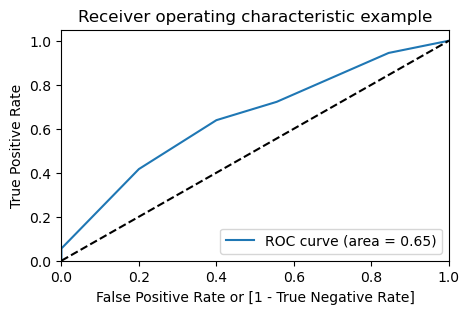

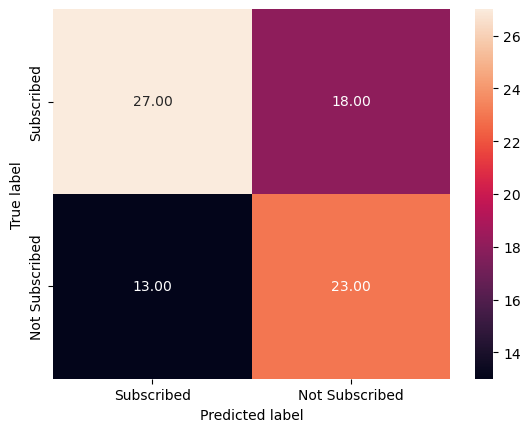

In [97]:
## Invoking draw_roc_curve with the KNN model
draw_roc_curve( knn_clf, test_X, test_Y )
pred_y = knn_clf.predict(test_X)
draw_cm(test_Y, pred_y)

In [98]:
print( metrics.classification_report(test_Y, pred_y ))

              precision    recall  f1-score   support

           0       0.68      0.60      0.64        45
           1       0.56      0.64      0.60        36

    accuracy                           0.62        81
   macro avg       0.62      0.62      0.62        81
weighted avg       0.62      0.62      0.62        81



### kNN - Grid Search

Finding the optimal parameters

In [99]:
## Importing GridSearchCV
from sklearn.model_selection import GridSearchCV
## Creating a dictionary with hyperparameters and possible values
## for searching
tuned_parameters = [{
    'n_neighbors': range(5,10),
    'metric': ['canberra', 'euclidean', 'minkowski']
}]

## Configuring grid search
clf = GridSearchCV(
    KNeighborsClassifier(),
    tuned_parameters,
    cv=10,
    scoring='roc_auc'
)
## fit the search with training set
clf.fit(train_X, train_Y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['canberra', 'euclidean', 'minkowski'],
                          'n_neighbors': range(5, 10)}],
             scoring='roc_auc')

In [100]:
clf.best_score_

0.8841351010101011

In [101]:
clf.best_params_

{'metric': 'canberra', 'n_neighbors': 9}

Grid search optimises the accuracy from `0.62` to `0.88`

## Random Forest

In [102]:
## Importing Random Forest Classifier from the sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
## Initializing the Random Forest Classifier with max_dept and
## n_estimators
radm_clf = RandomForestClassifier(max_depth=10, n_estimators=10)
radm_clf.fit(train_X, train_Y)

RandomForestClassifier(max_depth=10, n_estimators=10)

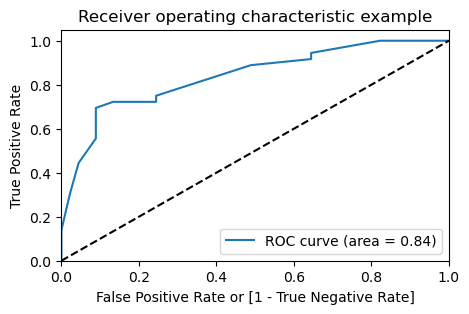

In [103]:
draw_roc_curve( radm_clf, test_X, test_Y );

### Random Forest - Grid Search

Finding the optimal parameters

In [104]:
## Configuring parameters and values for searched
tuned_parameters = [{
    'max_depth': [10, 15],
    'n_estimators': [10,20],
    'max_features': ['sqrt', 0.2]
}]

## Initializing the RF classifier
radm_clf = RandomForestClassifier()
## Configuring search with the tunable parameters
clf = GridSearchCV(
    radm_clf,
    tuned_parameters,
    cv=5,
    scoring='roc_auc'
)

## Fitting the training set
clf.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [10, 15], 'max_features': ['sqrt', 0.2],
                          'n_estimators': [10, 20]}],
             scoring='roc_auc')

In [105]:
clf.best_score_

0.9129901960784315

In [106]:
clf.best_params_

{'max_depth': 10, 'max_features': 0.2, 'n_estimators': 20}

In [107]:
## Initializing the Random Forest Model with the optimal values
radm_clf = RandomForestClassifier(
    max_depth=15,
    n_estimators=20,
    # max_features = 'auto'
)

## Fitting the model with the training set
radm_clf.fit( train_X, train_Y )

RandomForestClassifier(max_depth=15, n_estimators=20)

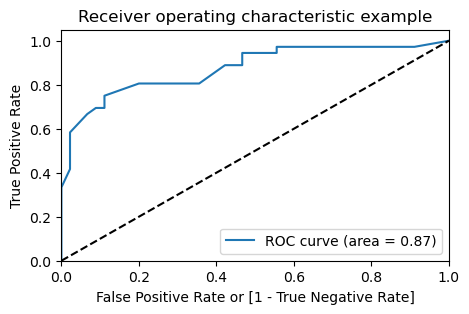

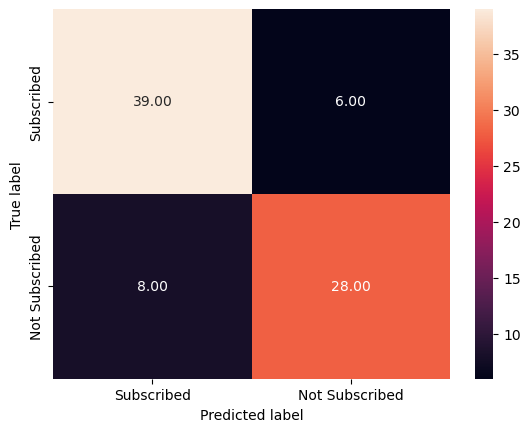

In [108]:
draw_roc_curve( clf, test_X, test_Y )
pred_y = radm_clf.predict( test_X )
draw_cm( test_Y, pred_y )

In [109]:
print( metrics.classification_report( test_Y, pred_y ) )

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        45
           1       0.82      0.78      0.80        36

    accuracy                           0.83        81
   macro avg       0.83      0.82      0.82        81
weighted avg       0.83      0.83      0.83        81



Random forest gives an accuracy of `0.83`.

## Adaboost

In [125]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
ada_clf = AdaBoostClassifier(logreg_clf, n_estimators=50)
ada_clf.fit(train_X, train_Y)

/nix/store/nyic9i5bvi0is3r93rlfysq4kppyz5nh-python3-3.10.12-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/nix/store/nyic9i5bvi0is3r93rlfysq4kppyz5nh-python3-3.10.12-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

AdaBoostClassifier(estimator=LogisticRegression())

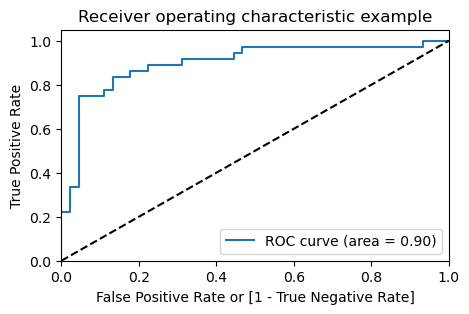

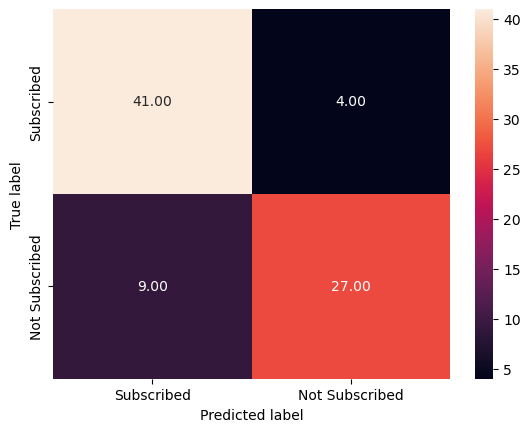

In [126]:
draw_roc_curve(ada_clf, test_X, test_Y)
pred_y = ada_clf.predict(test_X)
draw_cm( test_Y, pred_y )

In [127]:
print(metrics.classification_report(test_Y, pred_y))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        45
           1       0.87      0.75      0.81        36

    accuracy                           0.84        81
   macro avg       0.85      0.83      0.83        81
weighted avg       0.84      0.84      0.84        81



Accuracies:
1. kNN: `0.62`
2. Random Forest: `0.83`
3. AdaBoost: `0.84`

AdaBoost gives the best accuracy of `0.84` followed by Random Forest and kNN respectively.